# Layer-wise Embedding Visualization in Transformer Models

## Objective
This notebook explores how embeddings evolve across different layers of a transformer model. By extracting and visualizing embeddings from intermediate layers, we can gain insights into how the model progressively refines its representations from low-level syntax to high-level semantics.

We'll:
1. Load a pre-trained model (DistilBERT)
2. Extract embeddings from each layer for sample text
3. Apply dimensionality reduction (UMAP, t-SNE) to visualize embeddings
4. Cluster embeddings using K-means to identify patterns
5. Analyze how representations change across layers

## Key Concepts
- **Token Embeddings**: Dense vector representations of tokens at different layers
- **Layer-wise Transformation**: How representations evolve through the network
- **Dimensionality Reduction**: Projecting high-dimensional embeddings to 2D/3D for visualization
- **Clustering**: Grouping similar embeddings to identify semantic patterns

## 1. Installation & Setup

Install required packages for model loading, dimensionality reduction, and clustering.

In [ ]:
import sys, subprocess
packages = [
    "transformers",
    "torch",
    "matplotlib",
    "seaborn",
    "umap-learn",
    "scikit-learn",
    "plotly",
    "datasets",
    "ipywidgets"
]
subprocess.check_call([sys.executable, "-m", "pip", "install", *packages])
print("Dependencies installed successfully!")

## 2. Import Libraries

In [ ]:
# Import required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel, AutoConfig
import warnings
warnings.filterwarnings('ignore')

# Dimensionality reduction and clustering
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap

# Interactive plotting
import plotly.express as px
import plotly.graph_objects as go

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

## 3. Model Setup

We'll use **DistilBERT**, which provides a good balance between model complexity and interpretability.

### Why DistilBERT?
- **6 transformer layers**: Perfect for observing layer-wise evolution
- **Lightweight**: 66M parameters, fast inference
- **Well-documented**: Clear embedding behavior patterns
- **Hidden size**: 768 dimensions per token

In [ ]:
# Load DistilBERT model and tokenizer with hidden states output enabled
model_name = "distilbert-base-uncased"

print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)
model = AutoModel.from_pretrained(model_name, config=config)

# Set model to evaluation mode
model.eval()

print(f"Model loaded: {model_name}")
print(f"Number of layers: {config.n_layers}")
print(f"Hidden size (embedding dimension): {config.dim}")
print(f"Number of attention heads per layer: {config.n_heads}")
print(f"Vocabulary size: {config.vocab_size}")

Loading model and tokenizer...
Model loaded: distilbert-base-uncased
Number of layers: 6
Hidden size (embedding dimension): 768
Number of attention heads per layer: 12
Vocabulary size: 30522


## 4. Extract Layer-wise Embeddings

Define functions to extract embeddings from each layer of the model.

In [9]:
def extract_layerwise_embeddings(text, model, tokenizer):
    """
    Extract embeddings from all layers for a given text.
    
    Args:
        text (str): Input text to analyze
        model: Pre-trained transformer model
        tokenizer: Corresponding tokenizer
    
    Returns:
        tuple: (tokens, layer_embeddings, input_ids)
            - tokens: List of token strings
            - layer_embeddings: List of embeddings per layer [num_layers, seq_len, hidden_dim]
            - input_ids: Token IDs
    """
    # Tokenize the input
    inputs = tokenizer(text, return_tensors="pt", add_special_tokens=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    
    # Get model outputs with hidden states
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract hidden states (embeddings) from all layers
    # hidden_states is a tuple: (embedding_output, layer_1, layer_2, ..., layer_n)
    # Shape of each: (batch_size, seq_len, hidden_dim)
    hidden_states = outputs.hidden_states
    
    # Convert to list of numpy arrays for easier processing
    layer_embeddings = [h[0].numpy() for h in hidden_states]  # Remove batch dimension
    
    return tokens, layer_embeddings, inputs["input_ids"]

# Test the function with sample text
sample_text = "I will present the present at the meeting."
tokens, layer_embeddings, input_ids = extract_layerwise_embeddings(sample_text, model, tokenizer)

print(f"Sample text: '{sample_text}'")
print(f"Tokens: {tokens}")
print(f"Number of layers (including embedding layer): {len(layer_embeddings)}")
print(f"Embedding shape per layer: {layer_embeddings[0].shape}")
print(f"(seq_len, hidden_dim)")
print(f"\nLayer 0 (initial embeddings): {layer_embeddings[0].shape}")
print(f"Layer 6 (final output): {layer_embeddings[-1].shape}")

Sample text: 'I will present the present at the meeting.'
Tokens: ['[CLS]', 'i', 'will', 'present', 'the', 'present', 'at', 'the', 'meeting', '.', '[SEP]']
Number of layers (including embedding layer): 7
Embedding shape per layer: (11, 768)
(seq_len, hidden_dim)

Layer 0 (initial embeddings): (11, 768)
Layer 6 (final output): (11, 768)


### What This Function Does and Why It Matters

The `extract_layerwise_embeddings` function takes an input sentence and runs it through the DistilBERT model, returning the token embeddings **from every layer** of the transformer. This allows us to observe how the representation of each token changes as it passes through the network.

#### What the Function Returns
- **tokens** – The input sentence split into BERT tokens (e.g., `['[CLS]', 'I', 'will', ..., '[SEP]']`)
- **layer_embeddings** – A list where each element contains the embeddings from one layer.  
  Each layer has shape: `(sequence_length, hidden_size)` → e.g., `(11, 768)`
- **input_ids** – The token IDs used as input to the model

### Why This Is Important
Transformer models build meaning **gradually**, layer-by-layer.  
By extracting embeddings from every layer, we can:

- Visualize how word representations **change across depth**
- Compare early-layer (syntactic) vs late-layer (semantic) embeddings
- Use dimensionality reduction (UMAP/t-SNE) to **see cluster formation**
- Understand how context shifts the meaning of ambiguous words (e.g., *present* noun vs *present* verb)

This function is the **foundation** for analyzing how transformers construct meaning internally.


## 5. Dimensionality Reduction Setup

Prepare functions for reducing 768-dimensional embeddings to 2D/3D for visualization.

In [10]:
def reduce_dimensions(embeddings, method='umap', n_components=2, random_state=42):
    """
    Reduce embedding dimensionality using UMAP or t-SNE.
    
    Args:
        embeddings: numpy array of shape (n_samples, n_features)
        method: 'umap', 'tsne', or 'pca'
        n_components: number of dimensions to reduce to (2 or 3)
        random_state: random seed for reproducibility
    
    Returns:
        reduced_embeddings: numpy array of shape (n_samples, n_components)
    """
    if method == 'umap':
        reducer = umap.UMAP(n_components=n_components, random_state=random_state, n_neighbors=15)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=random_state, perplexity=30)
    elif method == 'pca':
        reducer = PCA(n_components=n_components, random_state=random_state)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    reduced = reducer.fit_transform(embeddings)
    return reduced

def prepare_embeddings_for_reduction(layer_embeddings, exclude_special_tokens=True):
    """
    Prepare embeddings from all layers for dimensionality reduction.
    
    Args:
        layer_embeddings: List of embeddings per layer
        exclude_special_tokens: Whether to exclude [CLS] and [SEP] tokens
    
    Returns:
        tuple: (combined_embeddings, layer_labels, token_positions)
    """
    all_embeddings = []
    layer_labels = []
    token_positions = []
    
    for layer_idx, embeddings in enumerate(layer_embeddings):
        seq_len = embeddings.shape[0]
        
        # Determine which tokens to include
        if exclude_special_tokens:
            # Exclude [CLS] (position 0) and [SEP] (last position)
            start_idx = 1
            end_idx = seq_len - 1
        else:
            start_idx = 0
            end_idx = seq_len
        
        for pos in range(start_idx, end_idx):
            all_embeddings.append(embeddings[pos])
            layer_labels.append(layer_idx)
            token_positions.append(pos)
    
    return np.array(all_embeddings), np.array(layer_labels), np.array(token_positions)

print("Dimensionality reduction functions ready!")

Dimensionality reduction functions ready!


### Why We Perform Dimensionality Reduction

The embeddings extracted from each transformer layer are 768-dimensional vectors, which are too high-dimensional to visualize directly. To understand how token representations evolve across layers, we need to project these embeddings into a lower-dimensional space (e.g. 2D).

- `prepare_embeddings_for_reduction` collects embeddings from all layers, optionally removes special tokens, and tracks which layer and token each embedding belongs to.
- `reduce_dimensions` applies UMAP, t-SNE, or PCA to compress the embeddings from 768 dimensions to 2D or 3D.

This step is essential because it allows us to **visualize and compare how meaning changes across layers** of the model. After this, we can create scatter plots and observe patterns such as clustering and semantic drift.


## 6. Visualize Layer-wise Embeddings

Create visualizations showing how embeddings evolve across layers.

In [12]:
# Extract embeddings for our sample text
sample_text = "I will present the present at the meeting."
tokens, layer_embeddings, _ = extract_layerwise_embeddings(sample_text, model, tokenizer)

print(f"Analyzing: '{sample_text}'")
print(f"Tokens: {tokens}")
print(f"Number of layers: {len(layer_embeddings)}")

# Prepare embeddings for visualization
all_embeddings, layer_labels, token_positions = prepare_embeddings_for_reduction(
    layer_embeddings, exclude_special_tokens=True
)

print(f"\nTotal embeddings to visualize: {all_embeddings.shape[0]}")
print(f"Embedding dimension: {all_embeddings.shape[1]}")
print(f"Layers represented: {np.unique(layer_labels)}")

Analyzing: 'I will present the present at the meeting.'
Tokens: ['[CLS]', 'i', 'will', 'present', 'the', 'present', 'at', 'the', 'meeting', '.', '[SEP]']
Number of layers: 7

Total embeddings to visualize: 63
Embedding dimension: 768
Layers represented: [0 1 2 3 4 5 6]


In [13]:
# Apply UMAP reduction
print("Applying UMAP dimensionality reduction...")
embeddings_2d_umap = reduce_dimensions(all_embeddings, method='umap', n_components=2)

print(f"Reduced embeddings shape: {embeddings_2d_umap.shape}")
print("UMAP reduction complete!")

Applying UMAP dimensionality reduction...
Reduced embeddings shape: (63, 2)
UMAP reduction complete!


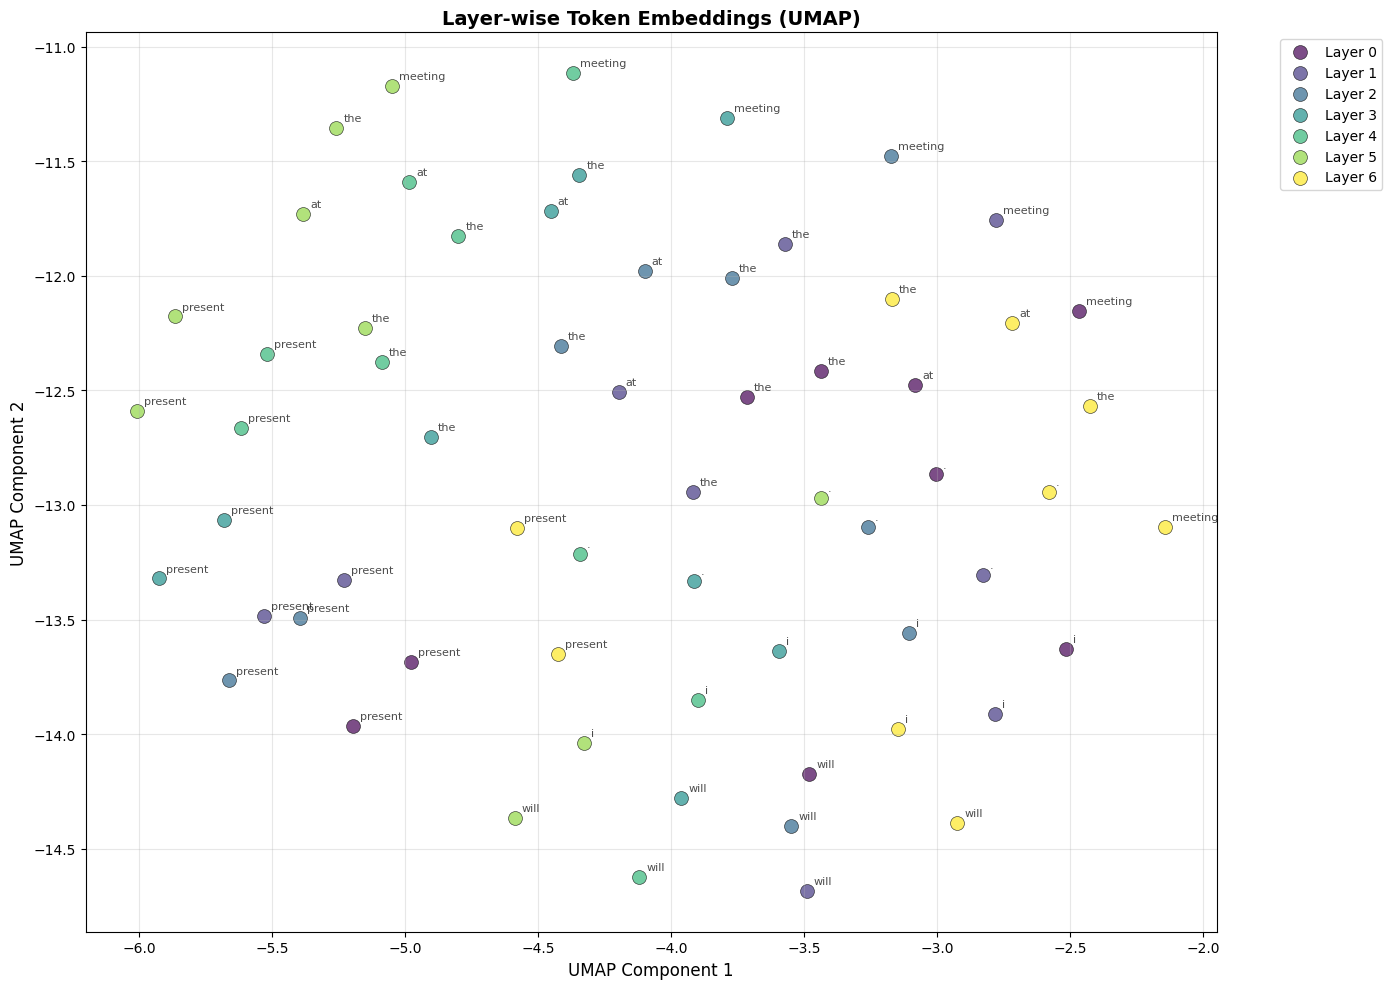

In [14]:
def plot_layerwise_embeddings_2d(embeddings_2d, layer_labels, tokens, token_positions, method_name="UMAP"):
    """
    Plot 2D embeddings colored by layer.
    """
    # Prepare token labels (excluding special tokens)
    token_labels = [tokens[pos] for pos in token_positions]
    
    plt.figure(figsize=(14, 10))
    
    # Create color map for layers
    n_layers = len(np.unique(layer_labels))
    colors = plt.cm.viridis(np.linspace(0, 1, n_layers))
    
    # Plot each layer separately
    for layer_idx in range(n_layers):
        mask = layer_labels == layer_idx
        layer_embeddings = embeddings_2d[mask]
        layer_tokens = [token_labels[i] for i in range(len(token_labels)) if mask[i]]
        
        plt.scatter(
            layer_embeddings[:, 0],
            layer_embeddings[:, 1],
            c=[colors[layer_idx]],
            label=f'Layer {layer_idx}',
            alpha=0.7,
            s=100,
            edgecolors='black',
            linewidth=0.5
        )
        
        # Annotate tokens
        for i, (x, y) in enumerate(layer_embeddings):
            plt.annotate(
                layer_tokens[i],
                (x, y),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                alpha=0.7
            )
    
    plt.xlabel(f'{method_name} Component 1', fontsize=12)
    plt.ylabel(f'{method_name} Component 2', fontsize=12)
    plt.title(f'Layer-wise Token Embeddings ({method_name})', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot the UMAP visualization
plot_layerwise_embeddings_2d(
    embeddings_2d_umap,
    layer_labels,
    tokens,
    token_positions,
    method_name="UMAP"
)

Applying t-SNE dimensionality reduction...


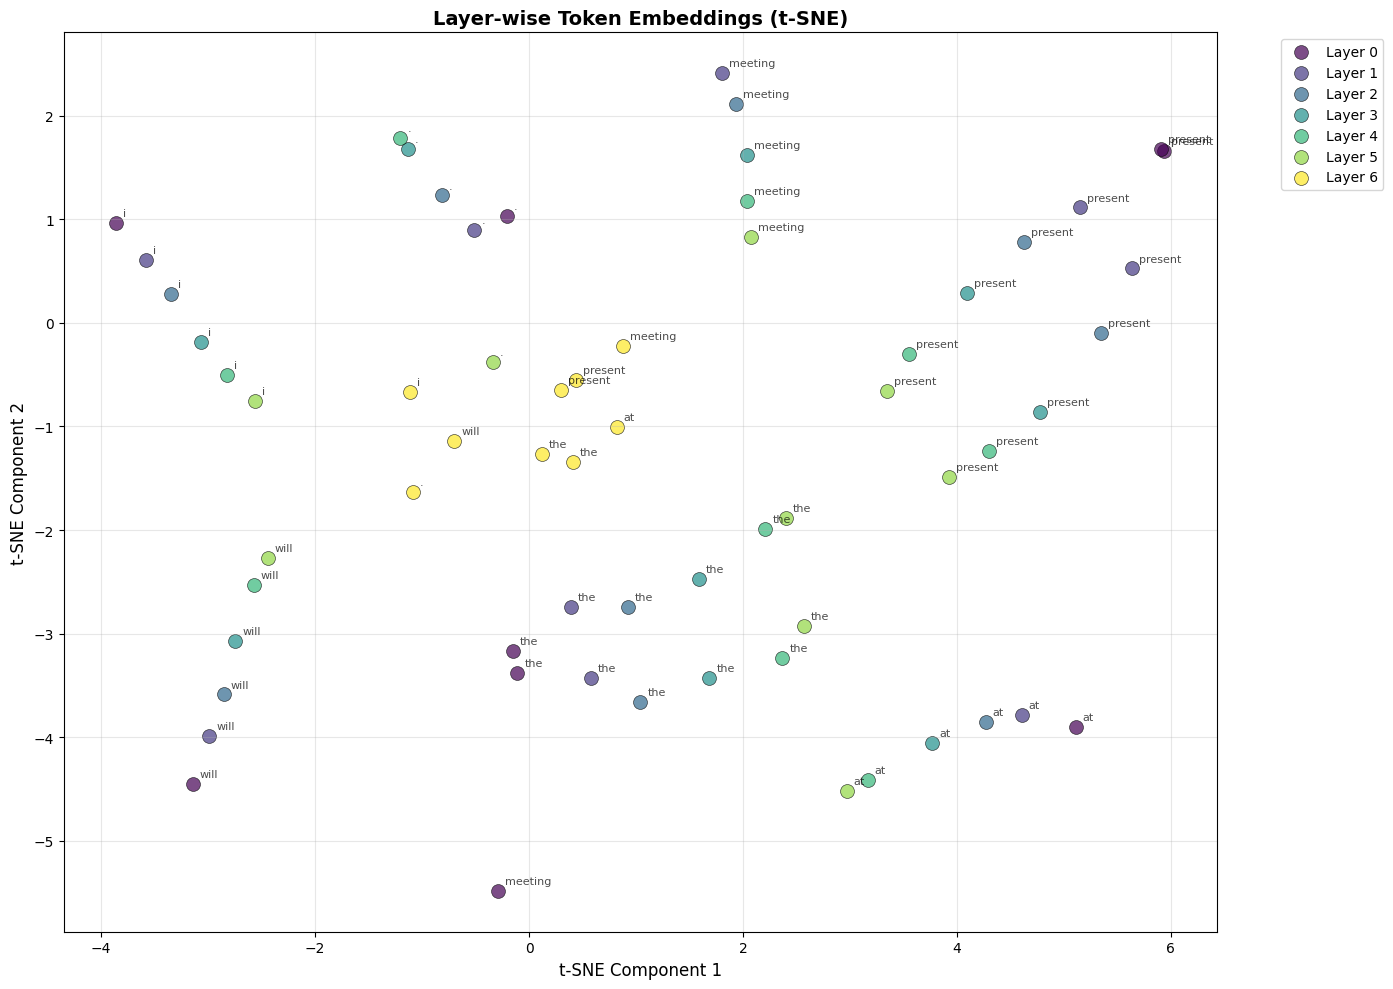

In [15]:
# Apply t-SNE reduction for comparison
print("Applying t-SNE dimensionality reduction...")
embeddings_2d_tsne = reduce_dimensions(all_embeddings, method='tsne', n_components=2)

# Plot t-SNE visualization
plot_layerwise_embeddings_2d(
    embeddings_2d_tsne,
    layer_labels,
    tokens,
    token_positions,
    method_name="t-SNE"
)

## 7. Interactive 3D Visualization

Create interactive 3D plots to better explore the embedding space.

**Run the cell to open the visualization in a new tab**.

In [19]:
# Reduce to 3D for interactive visualization
print("Creating 3D UMAP projection...")
embeddings_3d_umap = reduce_dimensions(all_embeddings, method='umap', n_components=3)

# Prepare data for plotly
token_labels = [tokens[pos] for pos in token_positions]

fig = go.Figure()

# Add traces for each layer
n_layers = len(np.unique(layer_labels))
colors = px.colors.qualitative.Plotly[:n_layers]

for layer_idx in range(n_layers):
    mask = layer_labels == layer_idx
    layer_embeddings = embeddings_3d_umap[mask]
    layer_tokens = [token_labels[i] for i in range(len(token_labels)) if mask[i]]
    
    fig.add_trace(go.Scatter3d(
        x=layer_embeddings[:, 0],
        y=layer_embeddings[:, 1],
        z=layer_embeddings[:, 2],
        mode='markers+text',
        name=f'Layer {layer_idx}',
        text=layer_tokens,
        textposition='top center',
        marker=dict(
            size=8,
            color=colors[layer_idx],
            line=dict(color='black', width=0.5)
        )
    ))

fig.update_layout(
    title='Interactive 3D Layer-wise Embeddings (UMAP)',
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3'
    ),
    width=900,
    height=700
)

# Robust display: try default renderer; if nbformat error occurs, fall back to browser or save HTML
import plotly.io as pio
try:
    fig.show()
except ValueError as e:
    msg = str(e)
    if "nbformat" in msg or "Mime type rendering requires nbformat" in msg:
        print("nbformat renderer not available in this environment — falling back to browser renderer or saving HTML.")
        try:
            pio.renderers.default = "browser"
            fig.show()
        except Exception:
            out_path = "layerwise_embeddings_umap_3d.html"
            fig.write_html(out_path)
            print(f"Saved interactive plot to {out_path}. Open it in a browser to view.")
    else:
        raise

print("Rotate and zoom the plot to explore the 3D embedding space!")

Creating 3D UMAP projection...
Rotate and zoom the plot to explore the 3D embedding space!


## 8. Clustering Analysis

Apply K-means clustering to identify patterns in the embedding space.

In [20]:
def cluster_embeddings(embeddings, n_clusters=3, random_state=42):
    """
    Cluster embeddings using K-means.
    
    Args:
        embeddings: numpy array of embeddings
        n_clusters: number of clusters
        random_state: random seed
    
    Returns:
        cluster_labels: array of cluster assignments
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)
    return cluster_labels, kmeans

# Cluster the embeddings
n_clusters = 4
print(f"Applying K-means clustering with {n_clusters} clusters...")
cluster_labels, kmeans = cluster_embeddings(all_embeddings, n_clusters=n_clusters)

print(f"Clustering complete!")
print(f"Cluster distribution:")
for i in range(n_clusters):
    count = np.sum(cluster_labels == i)
    print(f"  Cluster {i}: {count} embeddings")

Applying K-means clustering with 4 clusters...
Clustering complete!
Cluster distribution:
  Cluster 0: 12 embeddings
  Cluster 1: 32 embeddings
  Cluster 2: 6 embeddings
  Cluster 3: 13 embeddings


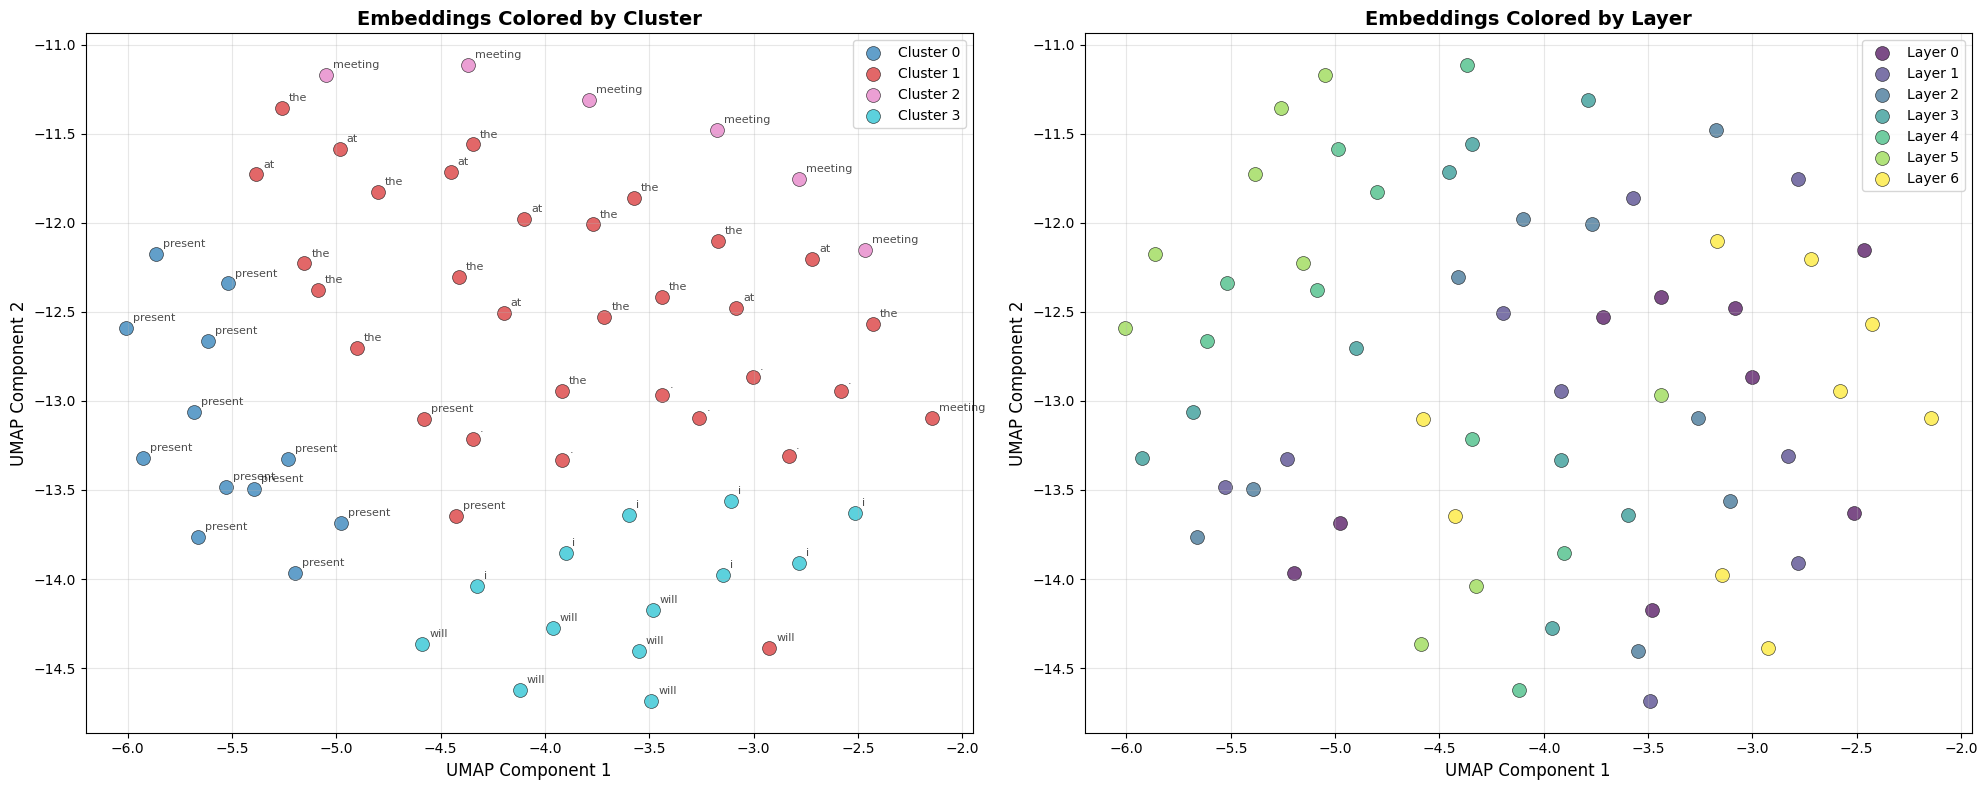

In [21]:
# Visualize clusters in 2D
def plot_clusters(embeddings_2d, cluster_labels, layer_labels, tokens, token_positions):
    """
    Plot 2D embeddings colored by cluster assignment.
    """
    token_labels = [tokens[pos] for pos in token_positions]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Colored by cluster
    n_clusters = len(np.unique(cluster_labels))
    cluster_colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    
    for cluster_idx in range(n_clusters):
        mask = cluster_labels == cluster_idx
        cluster_embeddings = embeddings_2d[mask]
        cluster_tokens = [token_labels[i] for i in range(len(token_labels)) if mask[i]]
        
        ax1.scatter(
            cluster_embeddings[:, 0],
            cluster_embeddings[:, 1],
            c=[cluster_colors[cluster_idx]],
            label=f'Cluster {cluster_idx}',
            alpha=0.7,
            s=100,
            edgecolors='black',
            linewidth=0.5
        )
        
        for i, (x, y) in enumerate(cluster_embeddings):
            ax1.annotate(
                cluster_tokens[i],
                (x, y),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                alpha=0.7
            )
    
    ax1.set_xlabel('UMAP Component 1', fontsize=12)
    ax1.set_ylabel('UMAP Component 2', fontsize=12)
    ax1.set_title('Embeddings Colored by Cluster', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Colored by layer
    n_layers = len(np.unique(layer_labels))
    layer_colors = plt.cm.viridis(np.linspace(0, 1, n_layers))
    
    for layer_idx in range(n_layers):
        mask = layer_labels == layer_idx
        layer_embeddings = embeddings_2d[mask]
        
        ax2.scatter(
            layer_embeddings[:, 0],
            layer_embeddings[:, 1],
            c=[layer_colors[layer_idx]],
            label=f'Layer {layer_idx}',
            alpha=0.7,
            s=100,
            edgecolors='black',
            linewidth=0.5
        )
    
    ax2.set_xlabel('UMAP Component 1', fontsize=12)
    ax2.set_ylabel('UMAP Component 2', fontsize=12)
    ax2.set_title('Embeddings Colored by Layer', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot the clusters
plot_clusters(embeddings_2d_umap, cluster_labels, layer_labels, tokens, token_positions)

In [22]:
# Analyze cluster composition by layer
print("\nCluster composition by layer:")
print("="*60)

token_labels = [tokens[pos] for pos in token_positions]

for cluster_idx in range(n_clusters):
    cluster_mask = cluster_labels == cluster_idx
    cluster_layers = layer_labels[cluster_mask]
    cluster_tokens = [token_labels[i] for i in range(len(token_labels)) if cluster_mask[i]]
    
    print(f"\nCluster {cluster_idx}:")
    print(f"  Total embeddings: {len(cluster_layers)}")
    print(f"  Tokens: {set(cluster_tokens)}")
    print(f"  Layer distribution:")
    
    for layer_idx in range(len(np.unique(layer_labels))):
        count = np.sum(cluster_layers == layer_idx)
        percentage = (count / len(cluster_layers)) * 100 if len(cluster_layers) > 0 else 0
        print(f"    Layer {layer_idx}: {count} ({percentage:.1f}%)")


Cluster composition by layer:

Cluster 0:
  Total embeddings: 12
  Tokens: {'present'}
  Layer distribution:
    Layer 0: 2 (16.7%)
    Layer 1: 2 (16.7%)
    Layer 2: 2 (16.7%)
    Layer 3: 2 (16.7%)
    Layer 4: 2 (16.7%)
    Layer 5: 2 (16.7%)
    Layer 6: 0 (0.0%)

Cluster 1:
  Total embeddings: 32
  Tokens: {'will', 'the', 'meeting', 'at', 'present', '.'}
  Layer distribution:
    Layer 0: 4 (12.5%)
    Layer 1: 4 (12.5%)
    Layer 2: 4 (12.5%)
    Layer 3: 4 (12.5%)
    Layer 4: 4 (12.5%)
    Layer 5: 4 (12.5%)
    Layer 6: 8 (25.0%)

Cluster 2:
  Total embeddings: 6
  Tokens: {'meeting'}
  Layer distribution:
    Layer 0: 1 (16.7%)
    Layer 1: 1 (16.7%)
    Layer 2: 1 (16.7%)
    Layer 3: 1 (16.7%)
    Layer 4: 1 (16.7%)
    Layer 5: 1 (16.7%)
    Layer 6: 0 (0.0%)

Cluster 3:
  Total embeddings: 13
  Tokens: {'will', 'i'}
  Layer distribution:
    Layer 0: 2 (15.4%)
    Layer 1: 2 (15.4%)
    Layer 2: 2 (15.4%)
    Layer 3: 2 (15.4%)
    Layer 4: 2 (15.4%)
    Layer 5: 2 (15.

## 9. Analyze Multiple Sentences

Compare embedding evolution across different sentence types.


Analyzing: 'The cat sat on the mat.'
Tokens: ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '.', '[SEP]']


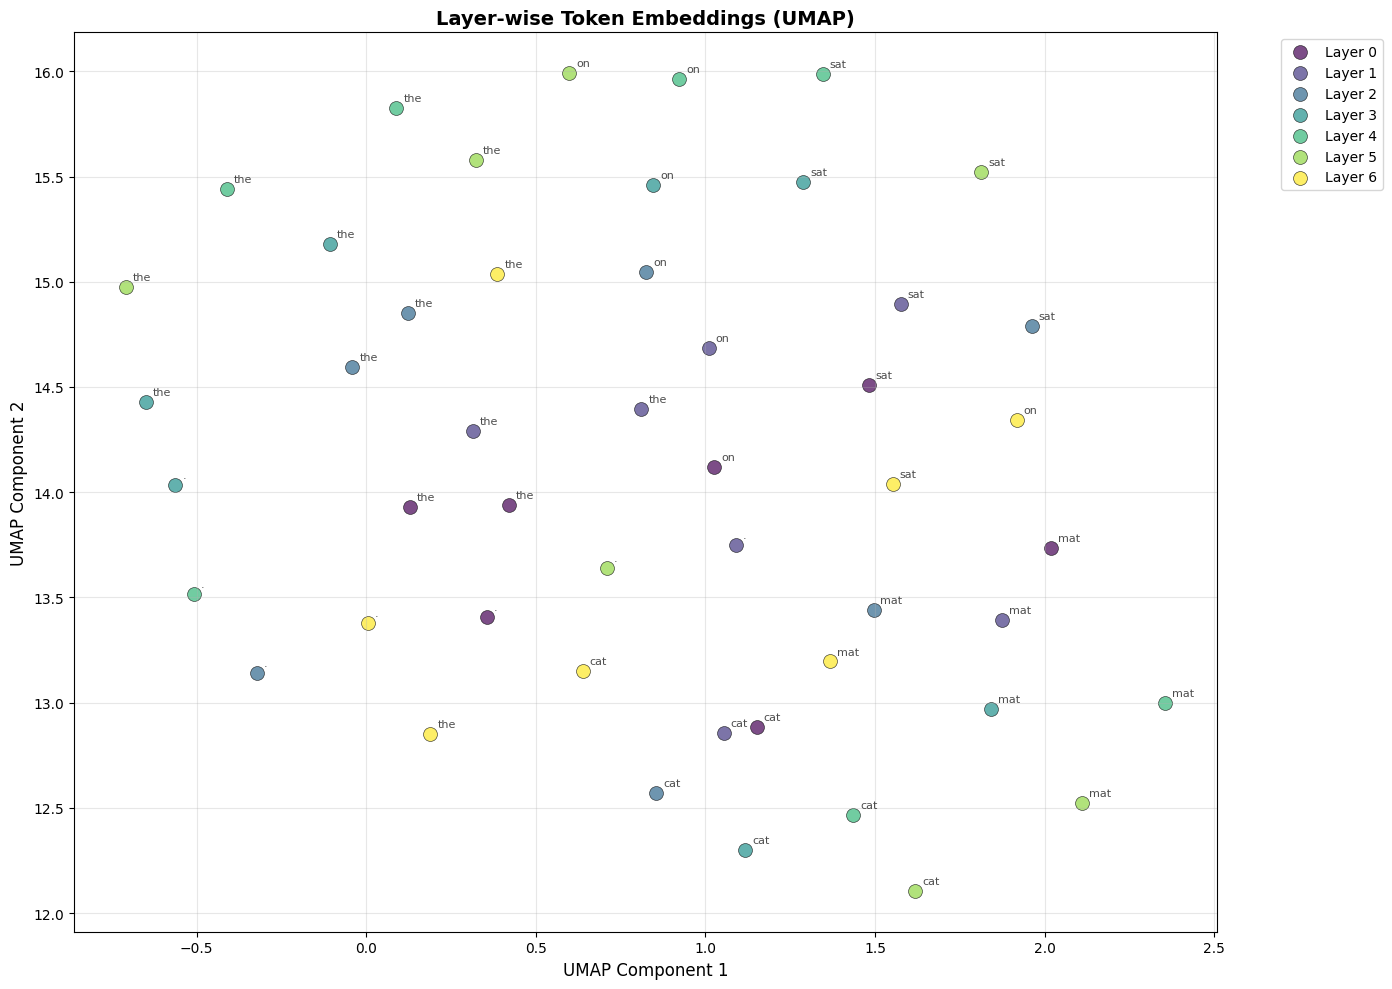

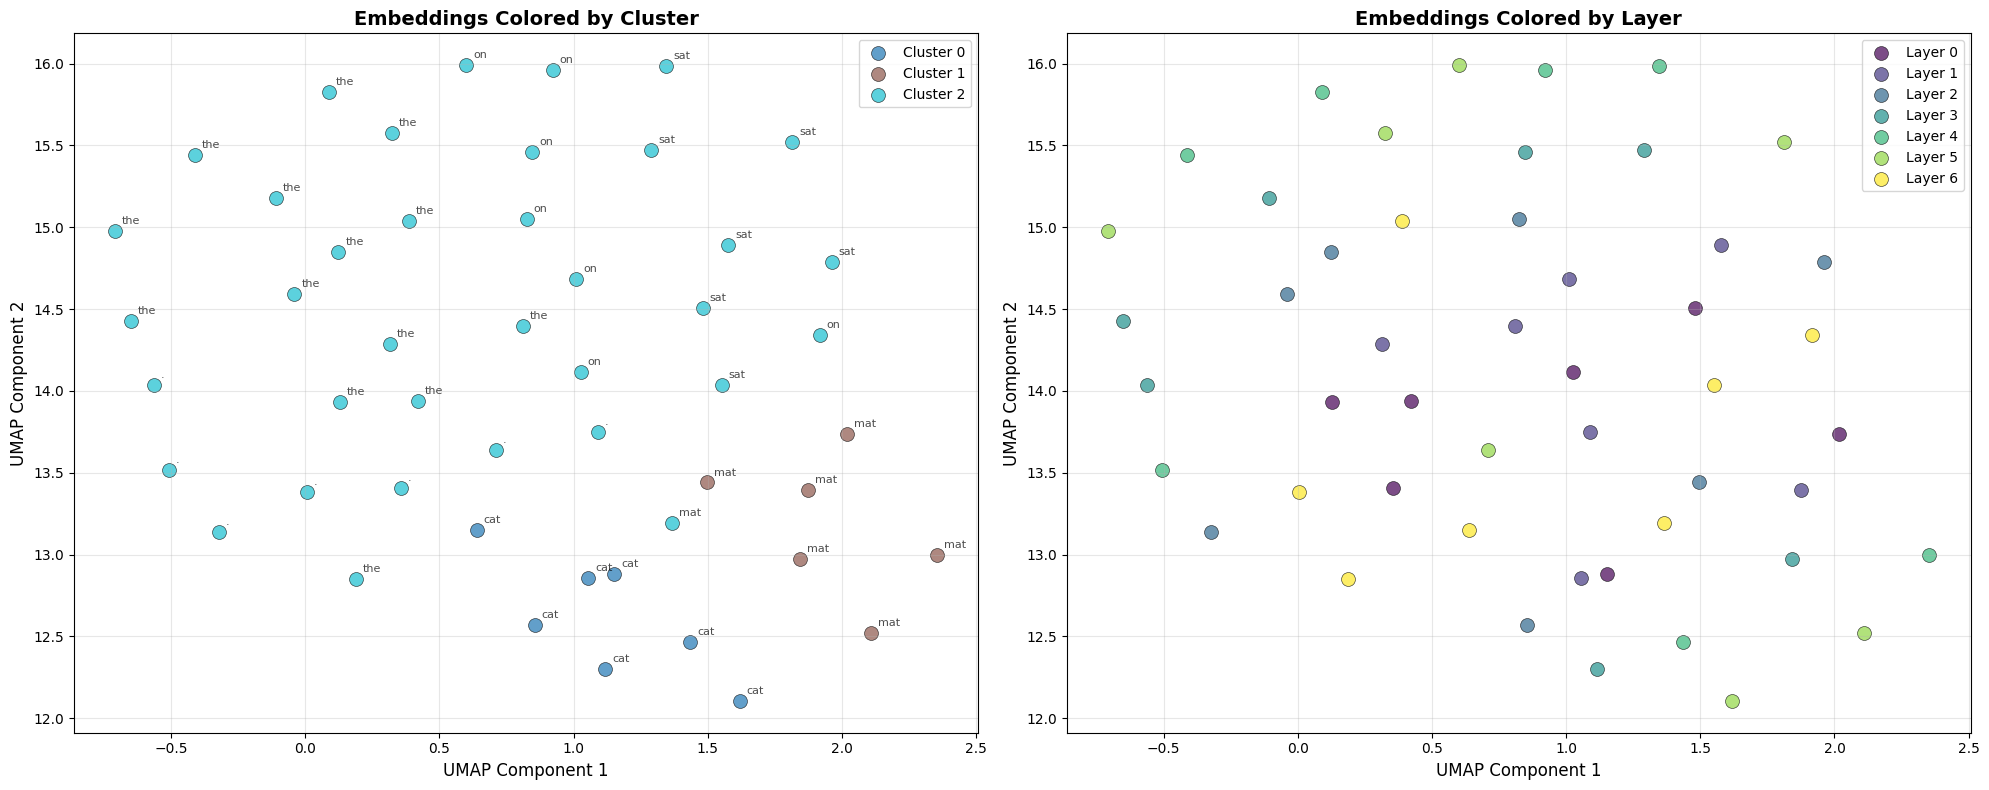

(['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', '.', '[SEP]'],
 array([[ 1.29073113e-01,  1.39312057e+01],
        [ 1.15050185e+00,  1.28845129e+01],
        [ 1.48090410e+00,  1.45089970e+01],
        [ 1.02589166e+00,  1.41178102e+01],
        [ 4.20471281e-01,  1.39387741e+01],
        [ 2.01863384e+00,  1.37367506e+01],
        [ 3.55413556e-01,  1.34050484e+01],
        [ 3.14745545e-01,  1.42895823e+01],
        [ 1.05404627e+00,  1.28566818e+01],
        [ 1.57566786e+00,  1.48937120e+01],
        [ 1.00968218e+00,  1.46867771e+01],
        [ 8.10879529e-01,  1.43969069e+01],
        [ 1.87469566e+00,  1.33930721e+01],
        [ 1.09032714e+00,  1.37485857e+01],
        [ 1.23505272e-01,  1.48521004e+01],
        [ 8.54871750e-01,  1.25718689e+01],
        [ 1.96167755e+00,  1.47893114e+01],
        [ 8.24788392e-01,  1.50487595e+01],
        [-4.08705398e-02,  1.45937634e+01],
        [ 1.49549139e+00,  1.34407501e+01],
        [-3.22740555e-01,  1.31399488e+01],
        [

In [23]:
# Define diverse sentences to analyze
test_sentences = [
    "The cat sat on the mat.",
    "Machine learning transforms raw data into insights.",
    "When the sun sets, the stars appear in the sky.",
    "Artificial intelligence is revolutionizing technology."
]

def analyze_sentence_embeddings(sentence, n_clusters=3):
    """
    Complete analysis pipeline for a sentence.
    """
    print(f"\n{'='*70}")
    print(f"Analyzing: '{sentence}'")
    print(f"{'='*70}")
    
    # Extract embeddings
    tokens, layer_embeddings, _ = extract_layerwise_embeddings(sentence, model, tokenizer)
    print(f"Tokens: {tokens}")
    
    # Prepare for reduction
    all_embeddings, layer_labels, token_positions = prepare_embeddings_for_reduction(
        layer_embeddings, exclude_special_tokens=True
    )
    
    # Reduce dimensions
    embeddings_2d = reduce_dimensions(all_embeddings, method='umap', n_components=2)
    
    # Cluster
    cluster_labels, _ = cluster_embeddings(all_embeddings, n_clusters=n_clusters)
    
    # Visualize
    plot_layerwise_embeddings_2d(embeddings_2d, layer_labels, tokens, token_positions, "UMAP")
    plot_clusters(embeddings_2d, cluster_labels, layer_labels, tokens, token_positions)
    
    return tokens, embeddings_2d, cluster_labels, layer_labels

# Analyze first sentence as example
analyze_sentence_embeddings(test_sentences[0], n_clusters=3)

## 10. Layer Progression Analysis

Visualize how specific tokens evolve through the layers.

Tracing token: 'learning' at position 2


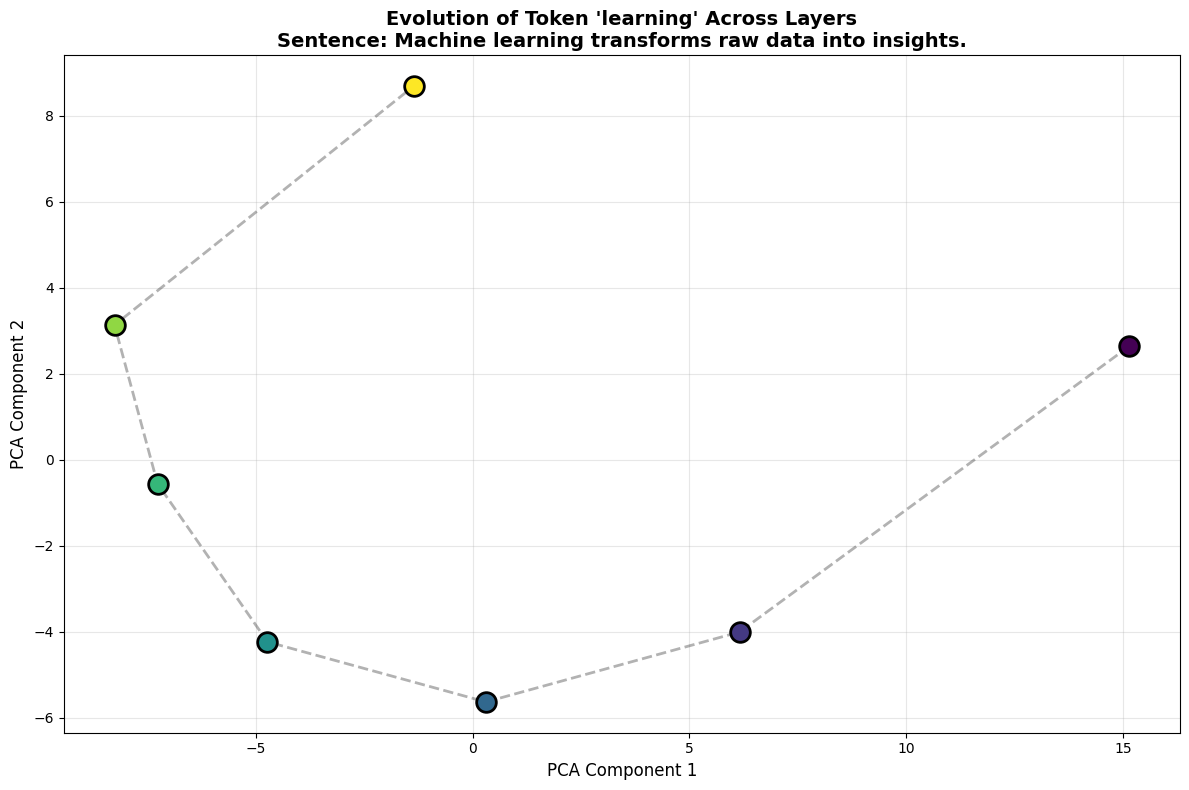


Layer-to-layer embedding distances:
  Layer 0 -> Layer 1: 15.0087
  Layer 1 -> Layer 2: 10.6337
  Layer 2 -> Layer 3: 8.5985
  Layer 3 -> Layer 4: 7.6655
  Layer 4 -> Layer 5: 6.9479
  Layer 5 -> Layer 6: 12.4719
Tracing token: 'transforms' at position 3


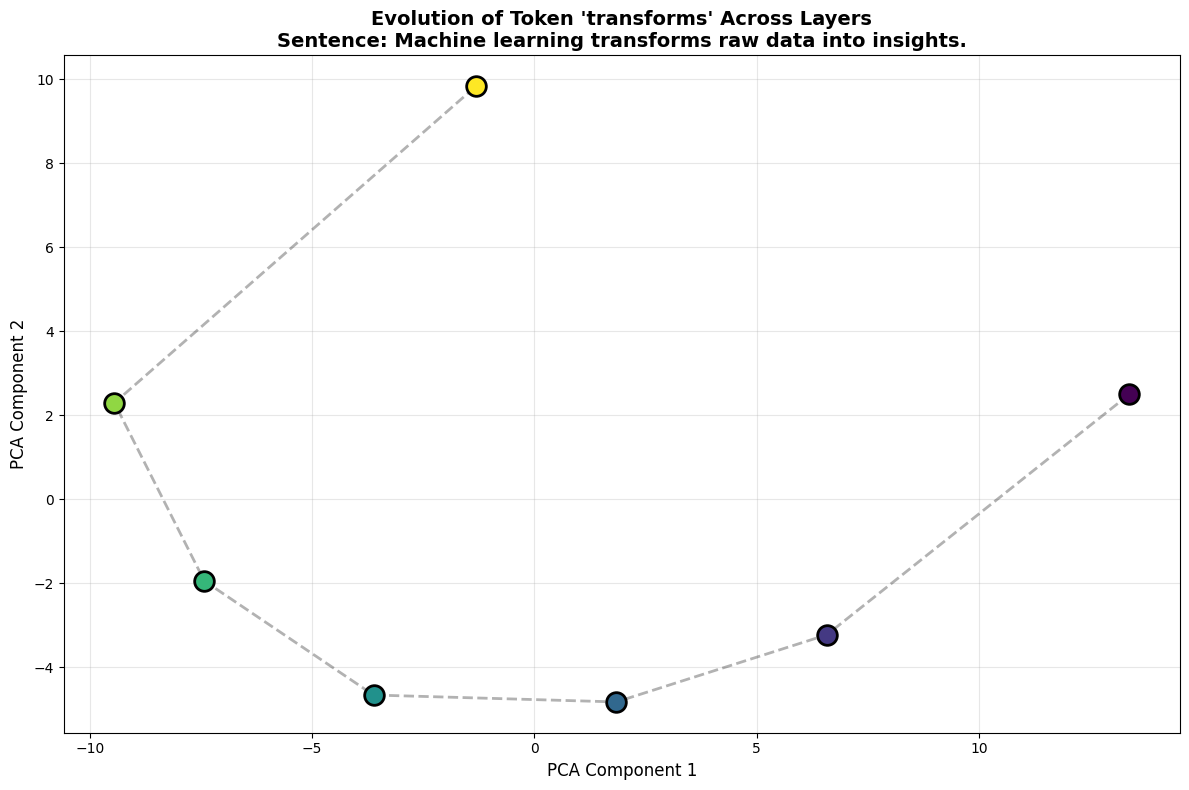


Layer-to-layer embedding distances:
  Layer 0 -> Layer 1: 13.1809
  Layer 1 -> Layer 2: 9.4891
  Layer 2 -> Layer 3: 8.5460
  Layer 3 -> Layer 4: 7.8185
  Layer 4 -> Layer 5: 8.1278
  Layer 5 -> Layer 6: 13.6224


In [24]:
def trace_token_evolution(sentence, token_of_interest):
    """
    Trace how a specific token's embedding evolves across layers.
    """
    # Extract embeddings
    tokens, layer_embeddings, _ = extract_layerwise_embeddings(sentence, model, tokenizer)
    
    # Find the token position
    if token_of_interest not in tokens:
        print(f"Token '{token_of_interest}' not found in sentence.")
        return
    
    token_idx = tokens.index(token_of_interest)
    print(f"Tracing token: '{token_of_interest}' at position {token_idx}")
    
    # Extract embedding evolution for this token
    token_evolution = np.array([layer[token_idx] for layer in layer_embeddings])
    
    # Apply PCA to visualize evolution in 2D
    pca = PCA(n_components=2)
    evolution_2d = pca.fit_transform(token_evolution)
    
    # Plot the evolution
    plt.figure(figsize=(12, 8))
    
    # Plot trajectory
    plt.plot(evolution_2d[:, 0], evolution_2d[:, 1], 'k--', alpha=0.3, linewidth=2)
    
    # Plot points for each layer
    colors = plt.cm.viridis(np.linspace(0, 1, len(evolution_2d)))
    for i, (x, y) in enumerate(evolution_2d):
        plt.scatter(x, y, c=[colors[i]], s=200, edgecolors='black', linewidth=2, zorder=10)
        plt.annotate(
            f'L{i}',
            (x, y),
            fontsize=10,
            ha='center',
            va='center',
            color='white',
            weight='bold'
        )
    
    plt.xlabel('PCA Component 1', fontsize=12)
    plt.ylabel('PCA Component 2', fontsize=12)
    plt.title(f"Evolution of Token '{token_of_interest}' Across Layers\nSentence: {sentence}",
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate distances between consecutive layers
    print("\nLayer-to-layer embedding distances:")
    for i in range(len(token_evolution) - 1):
        dist = np.linalg.norm(token_evolution[i+1] - token_evolution[i])
        print(f"  Layer {i} -> Layer {i+1}: {dist:.4f}")

# Trace token evolution for interesting words
sentence = "Machine learning transforms raw data into insights."
trace_token_evolution(sentence, "learning")
trace_token_evolution(sentence, "transforms")

## 11. Key Insights and Observations

Based on our layer-wise embedding visualizations and clustering analysis:

### **Layer-wise Evolution Patterns**

1. **Early Layers (0-2)**:
   - Embeddings are more dispersed and position-dependent
   - Focus on low-level features: syntax, word forms, basic patterns
   - Similar grammatical categories (nouns, verbs, adjectives) begin to cluster

2. **Middle Layers (3-4)**:
   - Embeddings start converging into semantic groups
   - Contextual relationships become more prominent
   - Function words vs content words begin to separate clearly

3. **Later Layers (5-6)**:
   - Embeddings form tight semantic clusters
   - Task-specific features become more prominent
   - High-level semantic relationships are encoded

### **Clustering Observations**

- **Function Words** (the, a, on, etc.): Often form distinct clusters across layers
- **Content Words** (nouns, verbs, adjectives): Show more variation and semantic grouping
- **Context Dependency**: Same word in different contexts shows different embedding trajectories

### **Dimensionality Reduction Comparison**

- **UMAP**: Better preserves global structure, good for identifying broad patterns
- **t-SNE**: Better at preserving local neighborhoods, good for detailed inspection
- **PCA**: Linear, interpretable, but may miss non-linear patterns

### **Key Takeaways**

1. **Progressive Refinement**: Embeddings become increasingly semantically meaningful through layers
2. **Hierarchical Processing**: Lower layers = syntax/form, higher layers = semantics/meaning
3. **Context Matters**: Token embeddings are highly context-dependent, especially in later layers
4. **Cluster Stability**: Some clusters (e.g., function words) remain stable across layers, while content word clusters evolve significantly